In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('CartPole-v1')
env.reset()


array([0.04873255, 0.00151558, 0.00790912, 0.03975826])

In [2]:
action_space = env.action_space.n
print(f"There are {action_space} possible actions.")


There are 2 possible actions.


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from collections import deque
import numpy as np

In [4]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                 size=batch_size,
                                 replace=False)
        return [self.buffer[i] for i in index]

In [5]:
mem = Memory(10)
[mem.add(i) for i in np.arange(10)]
mem.sample(5)

[0, 2, 6, 9, 7]

In [6]:
MEMORY_SIZE = 600
pretrain_length = 10
memory = Memory(max_size=MEMORY_SIZE)

state = env.reset() #env.decode(env.reset()))

done = False
step_limit = 600
step = 0
while step < step_limit:
    
    random_action = env.action_space.sample()
    new_state, reward, done, info = env.step(random_action)
    
    
    memory.add((state, random_action, new_state, reward, done, info))
    
    if done:
        state = env.reset() 
        
    else:
        state = new_state
        
    step += 1


In [7]:
memory.sample(3)


[(array([ 0.16259643,  0.44354756, -0.20166342, -0.99535918]),
  0,
  array([ 0.17146738,  0.25160983, -0.2215706 , -0.77217508]),
  1.0,
  True,
  {}),
 (array([ 0.22522695,  1.34652498,  0.0434256 , -0.75930645]),
  1,
  array([ 0.25215745,  1.54102252,  0.02823947, -1.03801462]),
  1.0,
  False,
  {}),
 (array([-0.0213989 ,  0.22315138,  0.02583269, -0.04648624]),
  0,
  array([-0.01693587,  0.02766871,  0.02490296,  0.25423389]),
  1.0,
  False,
  {})]

In [8]:
# predict the Q value of each action given the state
inputs = layers.Input(shape=(4,))
x = layers.Dense(50, activation="relu")(inputs)
x = layers.Dense(50, activation="relu")(x)
outputs = layers.Dense(2, activation="linear")(x)

model = tf.keras.Model(inputs, outputs)
model_target = tf.keras.Model(inputs, outputs)


model.output_shape
model(tf.random.uniform((3,4),-1,1))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.08752951,  0.36651555],
       [-0.04168215,  0.14394209],
       [-0.02554925,  0.16529503]], dtype=float32)>

In [9]:
def select_action(episode, model, state, min_epsilon, max_epsilon, decay_rate):

    # random number for explore/exploit trade-off
    epsilon = np.random.rand()

    # current ee prob
    explore_prob = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)

    if epsilon < explore_prob:
        action = env.action_space.sample()
    else:
        q_vals = model(tf.expand_dims(state, axis=0))
        action = np.argmax(q_vals)

    return action


In [10]:
state = env.reset()
[select_action(1, model, tf.random.normal((4,)), 0.0, 0.0, 0.01) for i in range(10)]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

In [11]:
def get_minibatch(model, memory, gamma, batch_size):

    # memory structure: (state, action, new_state, reward, done, info)

    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions =[each[1] for each in batch]
    next_states = np.array([each[2] for each in batch])
    rewards = [each[3] for each in batch]
    dones = tf.constant([each[4] for each in batch], dtype=tf.float32)

    # get q values from target model
    q_target = model(next_states)
    
    q_target = tf.reduce_max(q_target, axis=1)
    # set done q_target = reward and discount the others
    q_target = rewards + gamma * (1. - dones) * q_target

    return q_target, states, actions

get_minibatch(model, memory, 0.99, 3)

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.3121494, 1.060068 , 1.       ], dtype=float32)>,
 array([[ 0.0277234 ,  0.35306355, -0.01217392, -0.59877353],
        [-0.03926528,  0.04129011,  0.03298711, -0.01916819],
        [ 0.11184638,  0.18972477, -0.19914572, -0.66553929]]),
 [1, 0, 1])

In [12]:
total_episodes = 1000       # Total number of training episodes
max_steps = 200               # Max steps per episode
batch_size = 64

learning_rate = 0.01          # Learning rate
gamma = 0.9                  # Discounting rate

# Exploration parameters
epsilon = 1.0               # Exploration rate
max_epsilon = 1             # Exploration probability at start
min_epsilon = .1            # Minimum exploration probability 
decay_rate = 0.003          # Exponential decay rate for exploration prob

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

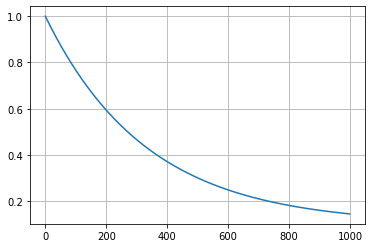

In [13]:
def explore(min_epsilon, max_epsilon, decay_rate, episode):
    return min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)
    

plt.plot(np.arange(1000), [explore(min_epsilon, max_epsilon, decay_rate, e) for e in np.arange(1000)])
plt.grid()
plt.show()

In [14]:
episode_reward_hist = []
episode_loss_hist = []

for episode in range(total_episodes):

    step = 0
    state = env.reset() #list(env.decode(env.reset()))
    done = False
    episode_reward = 0

    # play and record in memory
    while not done:
        step += 1
        action = select_action(episode, model, state, min_epsilon, max_epsilon, decay_rate)
        new_state, reward, done, info = env.step(action)
        
        memory.add((state, action, new_state, reward, done, info))
                
        
        if done:
            state = env.reset() #list(env.decode(env.reset()))
        else:
            state = new_state
        episode_reward += reward

    episode_reward_hist.append(episode_reward)
    
    # sample from memory and train
    q_target, states, actions = get_minibatch(model_target, memory, gamma, batch_size)

    with tf.GradientTape() as tape:
        
        q_values = model(states)
        
        masks = tf.one_hot(actions, env.action_space.n)
        
        q_action = tf.reduce_max(tf.multiply(q_values, masks), axis=1)

        loss = tf.keras.losses.MeanSquaredError()(q_target, q_action)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    episode_loss_hist.append(loss)

    if episode % 50 == 0:
        model_target.set_weights(model.get_weights())

    if episode % 100 ==0:
        print(f"Episode: {episode}\tLoss: {loss:.3f}\tEpisode reward: {episode_reward}")


Episode: 0	Loss: 1.171	Episode reward: 24.0
Episode: 100	Loss: 3.463	Episode reward: 18.0
Episode: 200	Loss: 0.477	Episode reward: 31.0
Episode: 300	Loss: 2.102	Episode reward: 140.0
Episode: 400	Loss: 0.041	Episode reward: 85.0
Episode: 500	Loss: 0.014	Episode reward: 500.0
Episode: 600	Loss: 1.287	Episode reward: 325.0
Episode: 700	Loss: 0.013	Episode reward: 233.0
Episode: 800	Loss: 0.005	Episode reward: 350.0
Episode: 900	Loss: 0.831	Episode reward: 296.0


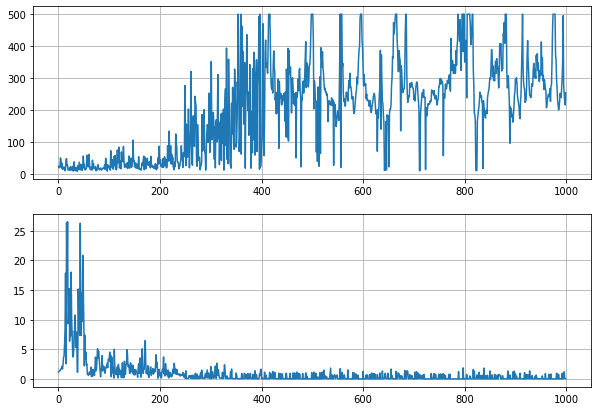

In [15]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(episode_reward_hist)
plt.grid()
plt.subplot(2,1,2)
plt.plot(episode_loss_hist)
plt.grid()
plt.show()


In [ ]:
from matplotlib import animation , rc
%matplotlib inline

fig = plt.figure()

frame = []
env.reset()

for episode in range(1):

    step = 0
    state = env.reset() #list(env.decode(env.reset()))
    done = False
    episode_reward = 0


    # play and record in memory

    while not done:
        step += 1
        action = select_action(episode, model, state, 0, 0, decay_rate)

        new_state, reward, done, info = env.step(action)
        img = plt.imshow(env.render('rgb_array'))
        frame.append([img])
        
        if done:
            state = env.reset() 
        else:
            state = new_state
        episode_reward += reward

    print(f"episode lasted {step} steps")
an = animation.ArtistAnimation(fig, frame, interval=100, repeat_delay=1000, blit=True)
rc('animation', html='jshtml')
an